# 1.生成weight和bias的mem file

将<font color = purple>**weight和bias**</font>的npy转成fixpoint格式的mem file  
`MODE = “NORMAL”`是根据神经网络模型提取出的npy文件转换成定点格式的mem file

In [2]:
#from utils import *
import numpy as np
from pathlib import Path
from fixedpoint import FixedPoint
import matplotlib.pyplot as plt
import random
import pprint
pp = pprint.PrettyPrinter(indent=4)

给出输入文件路径

In [3]:
stem_path = str(Path.cwd().parent)
WEIGHT_NPY_PATH = stem_path+'/etc/encoder.0.weight.npy'
BIAS_NPY_PATH   = stem_path+'/etc/encoder.0.bias.npy'
weights = np.load(WEIGHT_NPY_PATH)
bias    = np.load(BIAS_NPY_PATH)
print(weights)
print(bias)

[[ 4.61714491e-02 -4.86641042e-02  6.87794164e-02  3.81962173e-02
   4.97349799e-02  1.46025270e-01  5.64520024e-02  1.35894924e-01
   9.12814662e-02  1.75020128e-01  1.03703573e-01  9.12885293e-02
   1.15458950e-01  1.12033151e-01  4.53983918e-02  1.60164252e-01
   5.57718687e-02  8.53122771e-02  3.23279761e-02  1.48434132e-01
  -1.60553098e-01  7.45477021e-01  1.14839181e-01  6.17123805e-02
   3.61560881e-02  7.23892972e-02  6.48137629e-02  2.40803268e-02
   6.28587604e-03  3.40818837e-02  6.32042587e-02  2.77229249e-02
   4.27280366e-02  3.96201573e-02  3.08615211e-02  3.84189114e-02
   3.09909675e-02  5.70977060e-03  3.80497106e-04 -1.06896767e-02
  -4.20280080e-03  7.38318032e-03  8.66540223e-02  9.01583955e-03
  -8.58699158e-03  2.75642611e-02  1.12522002e-02  4.03919704e-02
   5.41922040e-02  2.89621074e-02 -3.02609685e-03  3.13733257e-02
  -4.99764283e-05  7.26521313e-02  1.66747738e-02  1.76839009e-02
   2.59591755e-03  6.82040770e-03 -1.14582875e-03  2.81337164e-02
   1.68023

查看一下权重和bias的维度，范围和精度，以保证定点数制参数选择的合理性

In [31]:
print(weights.shape)
print("weights max:",end=' ')
print(np.max(weights))
print("weights min:",end=' ')
print(np.min(weights))
print('='*40)
print(bias.shape)
print("bias max:",end=' ')
print(np.max(bias))
print("bias min:",end=' ')
print(np.min(bias))

(8, 96)
weights max: 0.745477
weights min: -0.44057184
(8,)
bias max: 0.06879704
bias min: -0.059737895


   
接着给出<font color=red>**重要参数和配置**</font>  


In [32]:
WEIGHT_W = 8 #权重的总体位宽
WEIGHT_INT_W = 1 #权重的整数位宽（含符号）
WEIGHT_FRAC_W = WEIGHT_W - WEIGHT_INT_W #权重的小数位宽
WEIGHT_NUM = 96 #输入维度，即一个神经元存储的权重个数

BIAS_W = 15
BIAS_INT_W =  1
BIAS_FRAC_W = BIAS_W - BIAS_INT_W

NEURON_NUM = 8 #输出维度，即神经元个数
LAYER_IDX = 0 #层编号，第0层

# 模式选择
MODE = "NORMAL"
# 输出文件夹
TARGET_FILE_DIR = stem_path+"/output/mem_file/"

评估一下定点表示浮点的误差

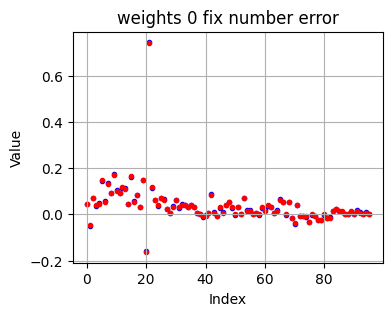

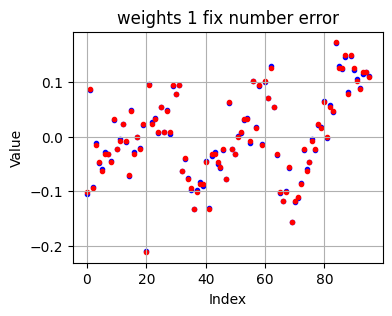

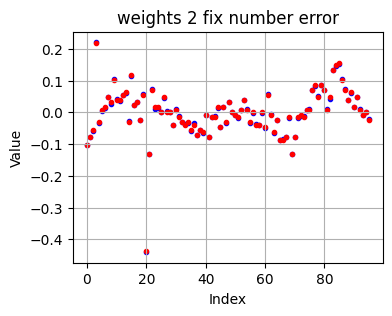

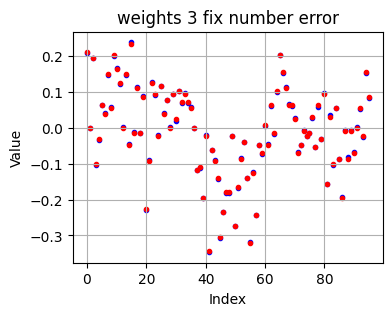

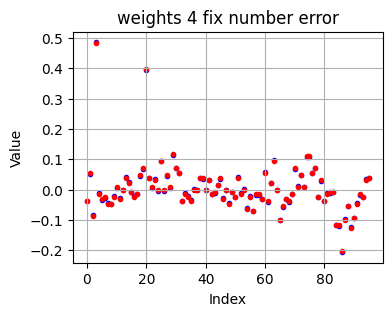

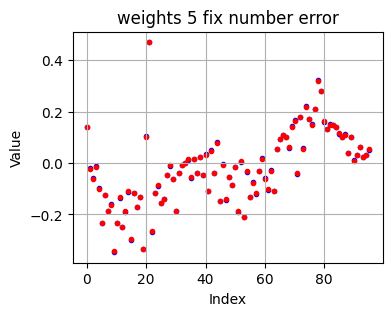

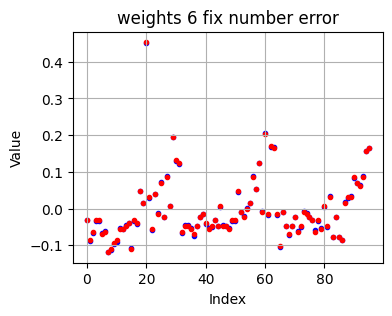

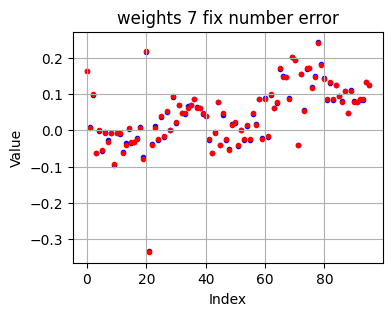

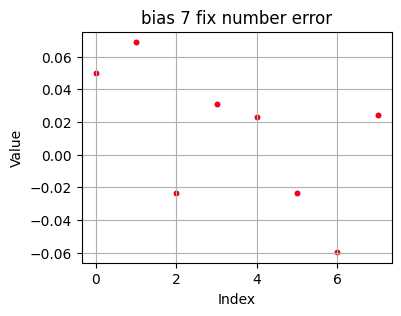

In [33]:
#权重定点误差
for idx in range(NEURON_NUM):
    src_lst = weights[idx]
    fix_object_lst = [ FixedPoint(i,
                           signed=True,
                           m=WEIGHT_INT_W,
                           n=WEIGHT_FRAC_W,
                           str_base=2,
                           overflow='clamp',
                           overflow_alert='warning') 
               for i in src_lst]
    fix_str_lst   = np.array([str(a)   for a in fix_object_lst])
    fix_float_lst = np.array([float(a) for a in fix_object_lst])
    
    # for j in range(len(src_lst)):
    #     print("{} -> {},{}".format(src_lst[j],fix_float_lst[j],fix_str_lst[j]))
    plt.figure(figsize=(4, 3))
    plt.scatter(np.arange(len(src_lst)), src_lst, color='blue', marker='.')
    plt.scatter(np.arange(len(fix_float_lst)), fix_float_lst, color='red', marker='.')
    plt.title('weights {} fix number error'.format(idx))
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()
    
# #bias定点误差
src_lst = bias
fix_object_lst = [ FixedPoint(i,
                       signed=True,
                       m=BIAS_INT_W,
                       n=BIAS_FRAC_W,
                       str_base=2,
                       overflow='clamp',
                       overflow_alert='warning') 
           for i in src_lst]
fix_str_lst   = np.array([str(a)   for a in fix_object_lst])
fix_float_lst = np.array([float(a) for a in fix_object_lst])
# for j in range(len(src_lst)):
#     print("{} -> {},{}".format(src_lst[j],fix_float_lst[j],fix_str_lst[j]))
plt.figure(figsize=(4, 3))
plt.scatter(np.arange(len(src_lst)), src_lst, color='blue', marker='.')
plt.scatter(np.arange(len(fix_float_lst)), fix_float_lst, color='red', marker='.')
plt.title('bias {} fix number error'.format(idx))
plt.xlabel('Index')
plt.ylabel('Value')
plt.grid(True)
plt.show()

定义生成权重的函数

In [34]:
def gen_weight_mem(WEIGHT_NUM):
    for i in range(NEURON_NUM):
        file = TARGET_FILE_DIR + "weight_mem_" + str(LAYER_IDX) + "_" + str(i) +".txt"
        src_lst = weights[i]
        fix_object_lst = [ FixedPoint(i,
                               signed=True,
                               m=WEIGHT_INT_W,
                               n=WEIGHT_FRAC_W,
                               str_base=2,
                               overflow='clamp',
                               overflow_alert='warning') 
                   for i in src_lst]
        fix_str_lst   = np.array([str(a)   for a in fix_object_lst])
        fix_float_lst = np.array([float(a) for a in fix_object_lst])
        
        # for j in range(len(src_lst)):
        #     print("{} -> {},{}".format(src_lst[j],fix_float_lst[j],fix_str_lst[j]))
        
        f = open(file,"w")
        for value in fix_str_lst:
            f.write(value+'\n')
        f.close()
def gen_bias_mem(WEIGHT_NUM):
    for i in range(NEURON_NUM):
        file = TARGET_FILE_DIR  + "bias_mem_" + str(LAYER_IDX) + "_" + str(i) +".txt"
        src_lst = [bias[i]]
        fix_object_lst = [ FixedPoint(i,
                               signed=True,
                               m=BIAS_INT_W,
                               n=BIAS_FRAC_W,
                               str_base=2,
                               overflow='clamp',
                               overflow_alert='warning') 
                   for i in src_lst]
        fix_str_lst   = np.array([str(a)   for a in fix_object_lst])
        f = open(file,"w")
        for value in fix_str_lst:
            f.write(value+'\n')
        f.close()  

In [35]:
if __name__ == "__main__":    
    if(MODE == "NORMAL"):
        gen_weight_mem(WEIGHT_NUM)
        gen_bias_mem(WEIGHT_NUM)

# 2.生成验证向量并进行软件仿真

In [4]:
import numpy as np
from pathlib import Path
from fixedpoint import FixedPoint
import matplotlib.pyplot as plt
import random
import pprint
stem_path = str(Path.cwd().parent)
WEIGHT_NPY_PATH = stem_path+'/etc/encoder.0.weight.npy'
BIAS_NPY_PATH   = stem_path+'/etc/encoder.0.bias.npy'
weights = np.load(WEIGHT_NPY_PATH)
bias    = np.load(BIAS_NPY_PATH)
print(weights.shape)
print(bias.shape)

(8, 96)
(8,)


有关输入的<font color=red>**重要配置**</font>

In [5]:
INPUT_W       = 16 #输入的总体位宽
INPUT_INT_W   = 9 #输入的整数位宽（含符号）
INPUIT_FRAC_W = INPUT_W - INPUT_INT_W #输入的小数位宽
NEURON_NUM = 8 #输出维度，即神经元个数
LAYER_IDX = 0 #层编号，第0层
WEIGHT_NUM = 96 #输入维度，即一个神经元存储的权重个数
# 输入测试文件位置
INPUT_SIM_FILE_PATH = stem_path+"/output/mem_file/input_sim.txt"

生成用于测试的input，一个WEIGHT_NUM大小的vertor，相当于一个采样点

In [6]:
# for software FC model
# input_vec_d = [random.uniform(-1,1) for _ in range(WEIGHT_NUM)]
input_vec_d = [0.5 for _ in range(WEIGHT_NUM)]
# for hardware input
input_vec_b_obj = [FixedPoint( i,
                               signed=True,
                               m=INPUT_INT_W,
                               n=INPUIT_FRAC_W,
                               str_base=2,
                               overflow='clamp',
                               overflow_alert='warning') 
                   for i in input_vec_d]
input_vec_b_str   = np.array([str(a)   for a in input_vec_b_obj])
input_vec_b_float = np.array([float(a) for a in input_vec_b_obj])
# save it
f = open(INPUT_SIM_FILE_PATH,"w")
for value in input_vec_b_str:
    f.write(value+'\n')
f.close()

软件仿真浮点和定点运算结果的比对

(1, 96) (96, 8) (1, 8)
////////////////////////////////////FLOAT SUM CALC0////////////////////////////////////
[MAC_R]:sum=1.867560026126739     
[ACT_R]:sum=0.9533724045100981    
////////////////////////////////////FIX SUM CALC0////////////////////////////////////
[MAC_R]:sum=1.87042236328125      
[ACT_R]:sum=0.9536323990053288    


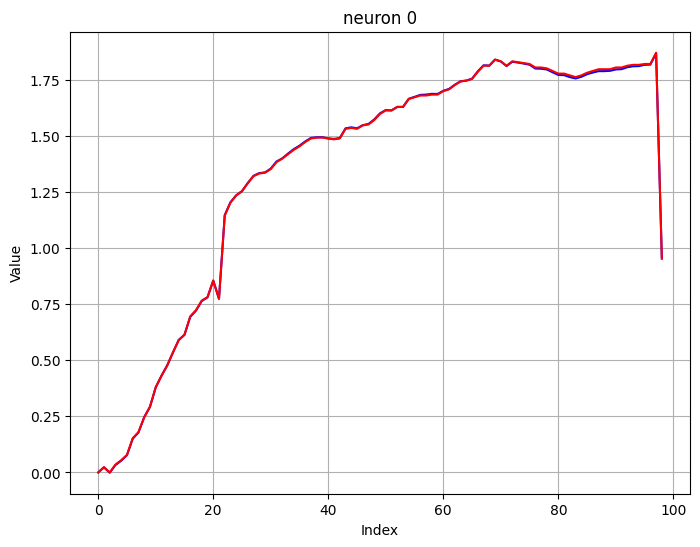

////////////////////////////////////FLOAT SUM CALC1////////////////////////////////////
[MAC_R]:sum=0.0957847999270598    
[ACT_R]:sum=0.09549293782376718   
////////////////////////////////////FIX SUM CALC1////////////////////////////////////
[MAC_R]:sum=0.09613037109375      
[ACT_R]:sum=0.09583534644815993   


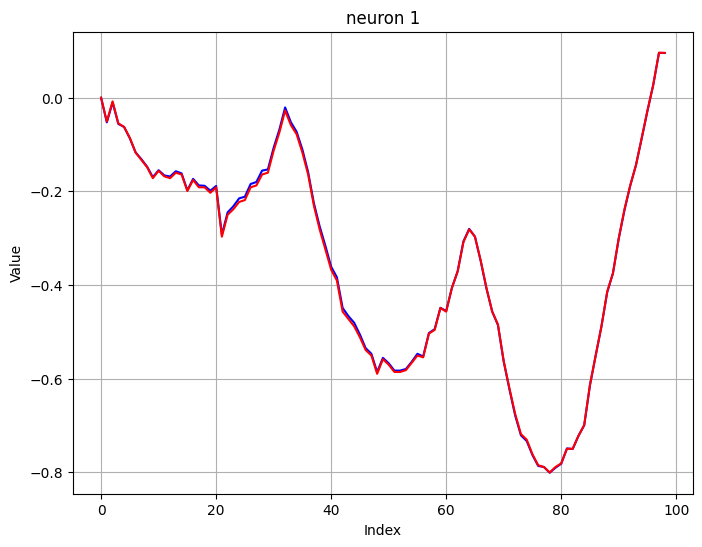

////////////////////////////////////FLOAT SUM CALC2////////////////////////////////////
[MAC_R]:sum=-0.0014744241925654933
[ACT_R]:sum=-0.0014744231241363827
////////////////////////////////////FIX SUM CALC2////////////////////////////////////
[MAC_R]:sum=-0.00384521484375     
[ACT_R]:sum=-0.0038451958924936086


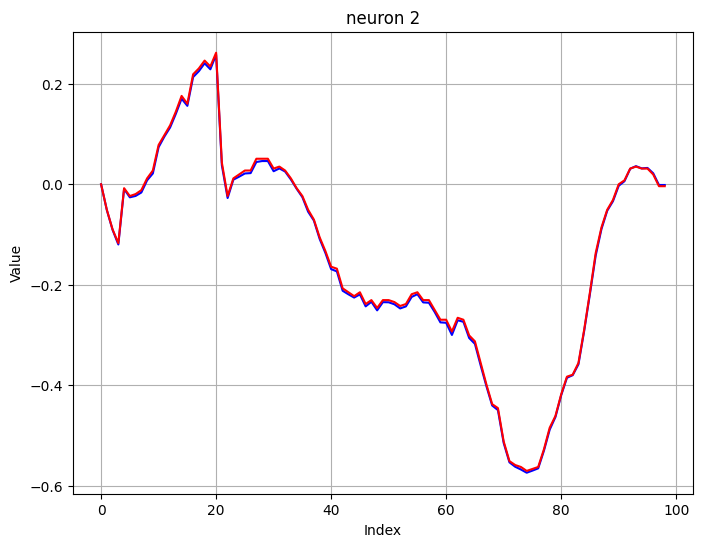

////////////////////////////////////FLOAT SUM CALC3////////////////////////////////////
[MAC_R]:sum=-0.4709934442071244   
[ACT_R]:sum=-0.4390016496931679   
////////////////////////////////////FIX SUM CALC3////////////////////////////////////
[MAC_R]:sum=-0.47698974609375     
[ACT_R]:sum=-0.4438295628023268   


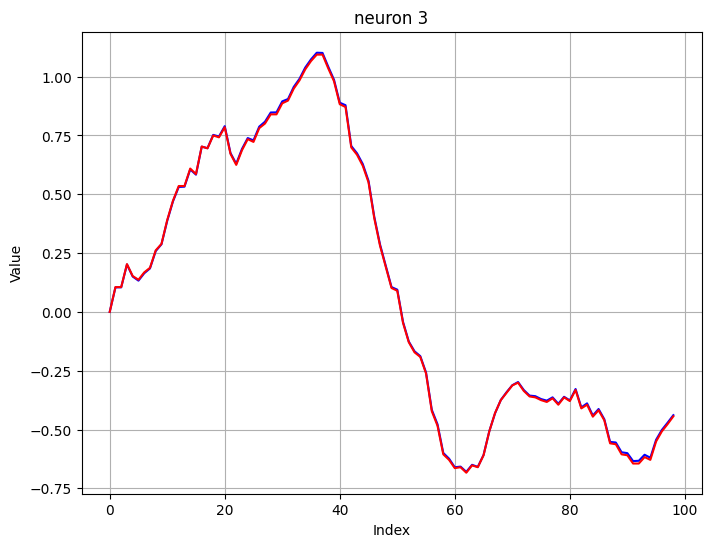

////////////////////////////////////FLOAT SUM CALC4////////////////////////////////////
[MAC_R]:sum=0.21984702651388943   
[ACT_R]:sum=0.21637225458659157   
////////////////////////////////////FIX SUM CALC4////////////////////////////////////
[MAC_R]:sum=0.22247314453125      
[ACT_R]:sum=0.2188739984716444    


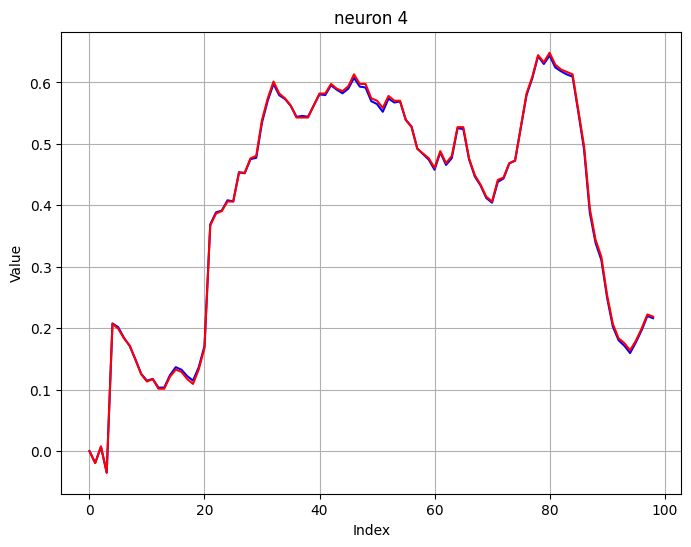

////////////////////////////////////FLOAT SUM CALC5////////////////////////////////////
[MAC_R]:sum=-0.7932360826525837   
[ACT_R]:sum=-0.6602383647471358   
////////////////////////////////////FIX SUM CALC5////////////////////////////////////
[MAC_R]:sum=-0.797119140625       
[ACT_R]:sum=-0.6624231285196973   


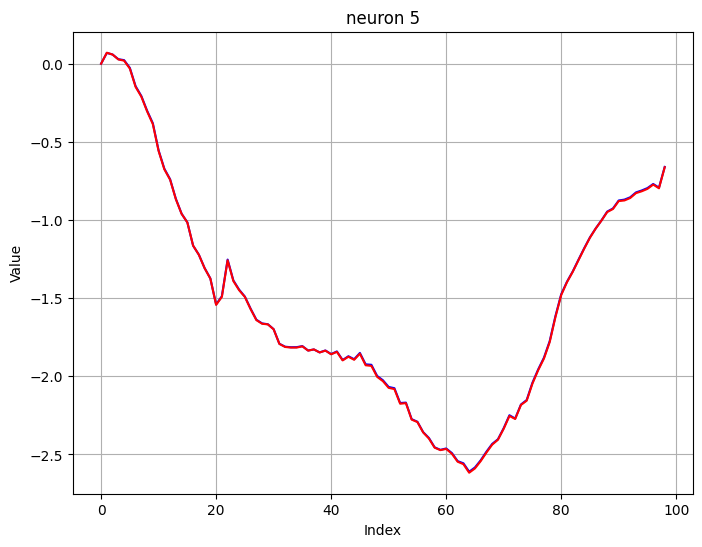

////////////////////////////////////FLOAT SUM CALC6////////////////////////////////////
[MAC_R]:sum=-0.1842210260219872   
[ACT_R]:sum=-0.18216493941758843  
////////////////////////////////////FIX SUM CALC6////////////////////////////////////
[MAC_R]:sum=-0.18084716796875     
[ACT_R]:sum=-0.17890104608958152  


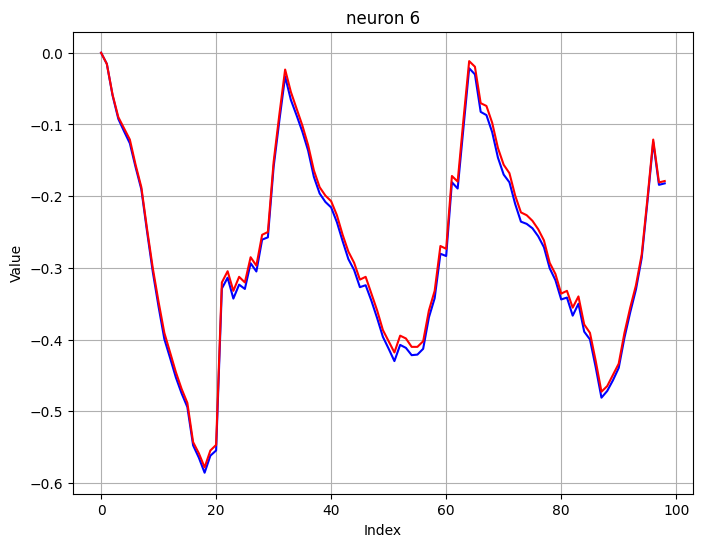

////////////////////////////////////FLOAT SUM CALC7////////////////////////////////////
[MAC_R]:sum=2.233245988663839     
[ACT_R]:sum=0.9772858422560721    
////////////////////////////////////FIX SUM CALC7////////////////////////////////////
[MAC_R]:sum=2.24322509765625      
[ACT_R]:sum=0.9777296845374343    


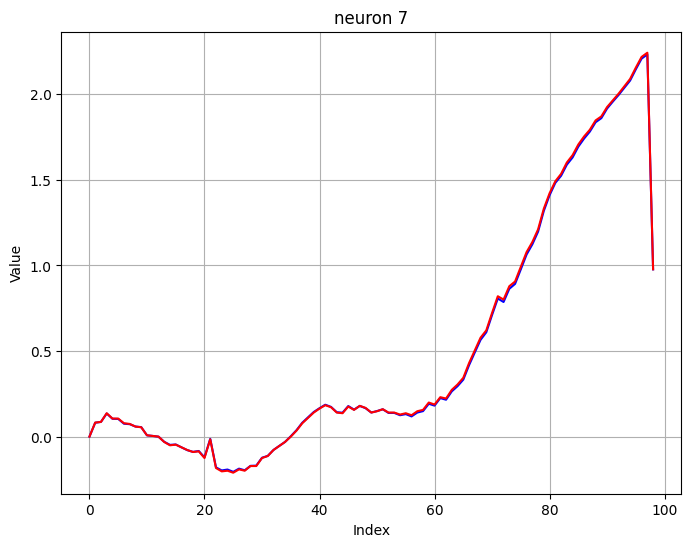

In [9]:
def FC_FLOAT_CALC(idx,input_vec_b_float,weights,bias):
    sum_d_lst   = []
    bias_column = bias[idx]
    weights_column = weights[:,idx]
    print('//'*18+'\33[1mFLOAT SUM CALC{}\33[0m'.format(idx)+'//'*18)
    sum = 0
    sum_d_lst.append(sum)
    for i in range(len(weights_column)):
        mul = input_vec_b_float[i] *  weights_column[i]
        #print('[{:<2}]:sum=\33[32;1m{:<22}\33[0m | sum+=\33[31;1m{}\33[0m'.format(i,sum,mul))
        sum += mul
        sum_d_lst.append(sum)
    #print('[{:<2}]:sum=\33[32;1m{:<22}\33[0m | sum+=\33[31;1m{}\33[0m'.format(i+1,sum,bias_column))
    sum += bias_column
    sum_d_lst.append(sum)
    print('[MAC_R]:sum=\33[32;1m{:<22}\33[0m'.format(sum))
    sum = np.tanh(sum)
    sum_d_lst.append(sum)
    print('[ACT_R]:sum=\33[32;1m{:<22}\33[0m'.format(sum))
    return sum_d_lst
def FC_FIX_CALC(idx,input_vec_b_float,weights,bias):
    sum_d_lst   = []
    bias_column = bias[idx]
    bias_column = FixedPoint(bias_column,
               signed=True,
               m=1,
               n=14,
               str_base=2,
               overflow='clamp',
               overflow_alert='warning')
    weights_column = weights[:,idx]
    print('//'*18+'\33[1mFIX SUM CALC{}\33[0m'.format(idx)+'//'*18)
    sum = FixedPoint(0,
                   signed=True,
                   m=10,
                   n=14,
                   str_base=2,
                   overflow='clamp',
                   overflow_alert='warning')
    sum_d_lst.append(float(sum))
    for i in range(len(weights_column)):
        a = FixedPoint(input_vec_b_float[i],
                       signed=True,
                       m=9,
                       n=7,
                       str_base=2,
                       overflow='clamp',
                       overflow_alert='warning')
        b = FixedPoint(weights_column[i],
                       signed=True,
                       m=1,
                       n=7,
                       str_base=2,
                       overflow='clamp',
                       overflow_alert='warning')
        mul = a * b
        # print('[{:<2}]:sum=\33[32;1m{:<22}\33[0m | sum+=\33[31;1m{}\33[0m'.format(i,float(sum),float(mul)))
        sum += mul
        sum_d_lst.append(float(sum))
    # print('[{:<2}]:sum=\33[32;1m{:<22}\33[0m | sum+=\33[31;1m{}\33[0m'.format(i+1,float(sum),float(bias_column)))
    sum += bias_column
    sum_d_lst.append(float(sum))
    print('[MAC_R]:sum=\33[32;1m{:<22}\33[0m'.format(float(sum)))
    sum = np.tanh(float(sum))
    sum_d_lst.append(sum)
    print('[ACT_R]:sum=\33[32;1m{:<22}\33[0m'.format(sum))
    return sum_d_lst
input_vec_b_float2 = np.array([input_vec_b_float])
weights_T = weights.T
bias_2D = np.array([bias])
print(input_vec_b_float2.shape,weights_T.shape,bias_2D.shape)
result_MAC = input_vec_b_float2 @ weights_T + bias_2D
result_out = [np.tanh(i) for i in result_MAC[0]]


sum_d_lst1_all = []
for idx in range(len(bias)):
    sum_d_lst1=FC_FLOAT_CALC(idx,input_vec_b_float2[0],weights_T,bias_2D[0])
    sum_d_lst2=FC_FIX_CALC(idx,input_vec_b_float2[0],weights_T,bias_2D[0])
    sum_d_lst1_all.append(sum_d_lst1)
    plt.figure(figsize=(8, 6))
    plt.plot(np.arange(len(sum_d_lst1)), sum_d_lst1, color='blue')
    plt.plot(np.arange(len(sum_d_lst2)), sum_d_lst2, color='red')
    plt.title('neuron {}'.format(idx))
    plt.xlabel('Index')
    plt.ylabel('Value')
    plt.grid(True)
    plt.show()    





## 前仿

## 后仿(综合后)

## 上板验证